In [1]:
import pycocotools
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

import skimage.io as io
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageDraw

from tqdm import tqdm
import json
import re
import shapely
import numpy as np

In [2]:
dataDir = Path('src/LIVECell_dataset_2021/images/livecell_train_val_images')
annFileDir = Path('src/LIVECell_dataset_2021/annotations/LIVECell')
annFileTrain = annFileDir / 'livecell_coco_train.json'
annFileVal = annFileDir / 'livecell_coco_val.json'

### LiveCell contains 9 different cell types, all but RatC6 have annotations (bounding boxes & instance segmentation)

In [3]:
!dir {dataDir}

A172  BT474  BV2  Huh7	MCF7  RatC6  SHSY5Y  SkBr3  SKOV3


In [4]:
def load_annots(fn):
    with open(fn) as f:
        annots = json.load(f)
    return annots

In [5]:
json_train = load_annots(annFileTrain)
json_val = load_annots(annFileVal)

### The relevant information is under the `images` and `annotations` keys. We create our own `categories` later and dont need `info` and `licenses`.

In [6]:
json_train.keys()

dict_keys(['images', 'annotations', 'categories', 'info', 'licenses'])

### Content of `images` and `annotations`:

In [7]:
from pprint import pprint

In [8]:
print(type(json_train['images']), type(json_train['annotations']))

<class 'list'> <class 'dict'>


In [9]:
pprint(json_train['images'][0])

{'file_name': 'BT474_Phase_A3_2_00d04h00m_3.tif',
 'height': 520,
 'id': 1,
 'original_filename': 'BT474_Phase_A3_2_00d04h00m_3.png',
 'url': 'https://darwin.v7labs.com/api/images/870028/original',
 'width': 704}


In [10]:
print(next(iter(json_train['annotations'])))

2


In [11]:
pprint(json_train['annotations']['2'])

{'area': 307.4786000000313,
 'bbox': [286.01, 287.73, 19.170000000000016, 20.269999999999982],
 'category_id': 1,
 'id': 2,
 'image_id': 1,
 'iscrowd': 0,
 'segmentation': [[288.02,
                   305.63,
                   286.01,
                   298.87,
                   286.01,
                   295.4,
                   288.02,
                   290.1,
                   293.86,
                   287.91,
                   297.51,
                   287.73,
                   300.44,
                   289.01,
                   304.27,
                   292.48,
                   304.64,
                   295.04,
                   305.18,
                   297.77,
                   305.18,
                   300.7,
                   303.91,
                   302.52,
                   301.17,
                   305.26,
                   297.33,
                   307.45,
                   294.59,
                   307.45,
                   290.58,
           

### Sample Data:

In [12]:
key = '101'
image_id = json_train['annotations'][key]['image_id']
poly = json_train['annotations'][key]['segmentation']

### Get `image_id` by `key`

In [16]:
def get_image_id(key, json_data):
    return json_data['annotations'][key]['image_id']

### Get `file_name` by `image_id`

In [17]:
def get_fn(image_id, json_data):
    for instance in json_data['images']:
        if instance['id'] == image_id:
            return instance['file_name']
    return False

In [19]:
fn = get_fn(image_id, json_train)
fn

'BT474_Phase_A3_2_00d04h00m_3.tif'

### Draw a bitmask from a polygon, return the bitmask as an array

In [20]:
def poly2mask(poly_list):
    img = Image.new('L', (704, 520), 0)
    ImageDraw.Draw(img).polygon(poly_list, outline=1, fill=1)
    mask = np.array(img, dtype = np.uint8)
    return np.asfortranarray(mask)

### Sanity Checks:

In [21]:
poly_arr = np.array(json_train['annotations'][key]['segmentation']).reshape(-1,2)
poly_list = [(x[0],x[1]) for x in list(poly_arr)]
mask = poly2mask(poly_list)
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

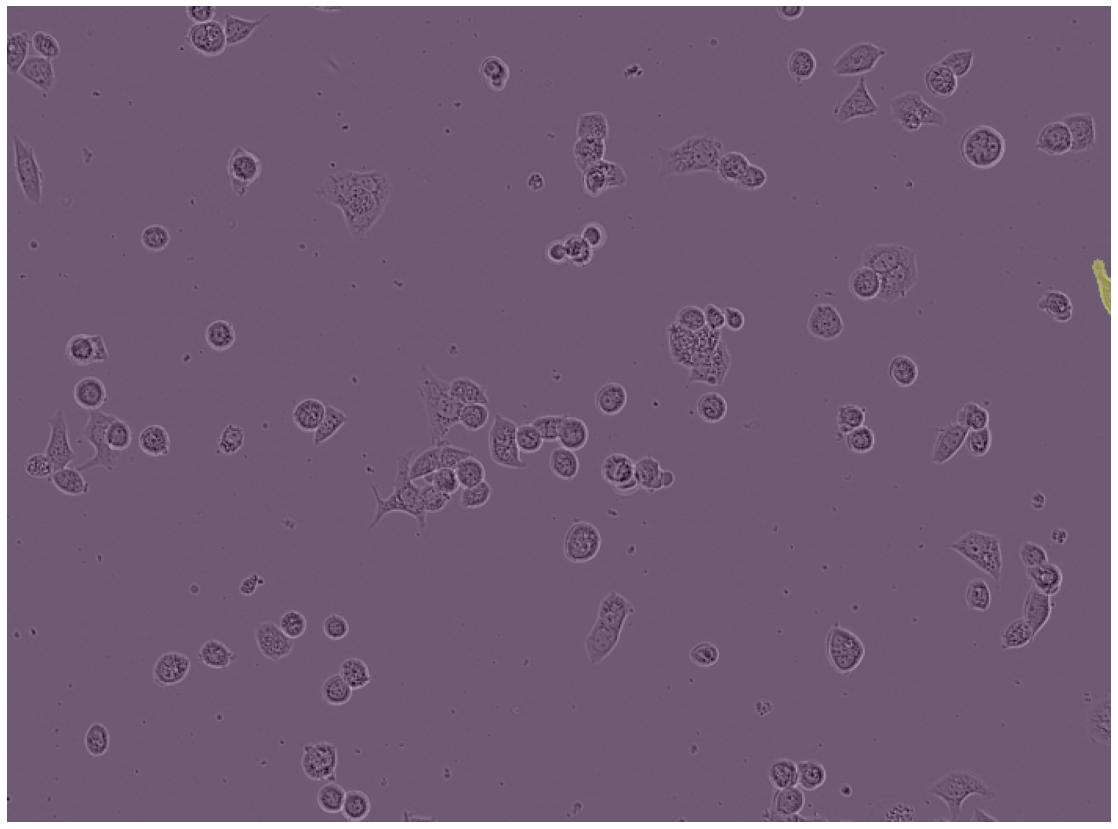

In [22]:
img_arr = np.array(Image.open('src/LIVECell_dataset_2021/images/png/' + fn[:-4] + '.png'))
fig = plt.figure(figsize = (20, 15))
plt.imshow(img_arr, cmap = 'gray')
plt.imshow(mask, alpha = 0.3)

plt.axis('off')

plt.show()

### Create categories dict to save categories as ints

In [23]:
categories = 'A172 BT474  BV2  Huh7 MCF7 SHSY5Y  SkBr3  SKOV3'.split()
categories_dict = {cat:i+1 for i,cat in enumerate(categories)}
print(categories_dict)

{'A172': 1, 'BT474': 2, 'BV2': 3, 'Huh7': 4, 'MCF7': 5, 'SHSY5Y': 6, 'SkBr3': 7, 'SKOV3': 8}


### Return categorie from `file_name`

In [24]:
def get_cell_name(fn):
    ## Assumes that you have run 'set_json_png' before, change to '….tiff' otherwise
    return re.search('(.*)_Phase_.*.png', fn).group(1)

In [27]:
print(get_cell_name(fn[:-4]+'.png'))

BT474


### Return categories int from `file_name`

In [25]:
def get_cell_category(fn):
    cell_name = get_cell_name(fn)
    return categories_dict[cell_name]

In [28]:
print(get_cell_category(fn[:-4]+'.png'))

2


## Rebuild the annotations to only contain necessary information and use run length encoding 

In [154]:
def annotate(key, json_data):
    ## …['segmentation'] is saved as (x0,y0,x1,y1,x2,y2,…)
    poly_arr = np.array(json_data['annotations'][key]['segmentation']).reshape(-1,2)
    poly_list = [(x[0],x[1]) for x in list(poly_arr)] 
    mask = poly2mask(poly_list)
    c_rle = maskUtils.encode(mask) ## run length encoding
    c_rle['counts'] = c_rle['counts'].decode('utf-8')
    
    ## Change file_name suffix to .png (from .tiff)
    image_id = get_image_id(key, json_data)
    fn = get_fn(image_id, json_data)
    fn = fn[:-4]+'.png'
    
    annotation = {
            'segmentation': c_rle, 
            'bbox': maskUtils.toBbox(c_rle).astype(int).tolist(),   ## Recalc `area` and `bbox`
            'area': maskUtils.area(c_rle).item(),
            'image_id': image_id, 
            'category_id':get_cell_category(fn), 
            'iscrowd':0, 
            'id':json_data['annotations'][key]['id']
    }
    return annotation

In [155]:
def coco_structure(json_data):
    cats = [{'name': name, 'id': id} for name, id in categories_dict.items()]
    images = [{'id': x['id'], 'width': x['width'], 'height': x['height'], 'file_name': x['file_name'][:-4]+'.png'} for x in json_data['images']]
    
    annotations = []
    for key in tqdm(json_data['annotations'].keys()):
        annotations.append(annotate(key, json_data))
        
    return {'categories': cats, 'images': images, 'annotations': annotations}

In [158]:
res_train = coco_structure(json_train)

100%|███████████████████████████████| 1018576/1018576 [10:24<00:00, 1631.94it/s]


In [159]:
with open('src/livecell_coco_train_encoded.json', 'w', encoding = 'utf-8') as g:
    json.dump(res_train, g, ensure_ascii = True)

In [156]:
res_val = coco_structure(json_val)

100%|█████████████████████████████████| 181610/181610 [01:31<00:00, 1983.93it/s]


In [157]:
with open('src/livecell_coco_val_encoded.json', 'w', encoding = 'utf-8') as g:
    json.dump(res_val, g, ensure_ascii = True)

---